In [4]:
# import libraries
!pip install lifetimes
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [5]:
#import dataset
data= pd.read_csv("C:/Users/rhizc/OneDrive/Desktop/MY PROJECTS/Online Retail-CLV prediction/online_retail.csv")
df = data.copy()
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


In [6]:
#replace outliers with threshold
data.describe([0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.98, 0.99, 1]).T

,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,98%,99%,100%,max
Quantity,1067371.0000,9.9389,172.7058,-80995.0000,-3.0000,1.0000,1.0000,1.0000,2.0000,2.0000,3.0000,5.0000,8.0000,12.0000,24.0000,30.0000,72.0000,100.0000,80995.0000,80995.0000
Price,1067371.0000,4.6494,123.5531,-53594.3600,0.2100,0.4200,0.6500,0.9500,1.2500,1.6500,2.1000,2.9500,3.7500,4.9500,7.9500,9.9500,14.9500,18.0000,38970.0000,38970.0000
Customer ID,824364.0000,15324.6385,1697.4645,12346.0000,12422.0000,12681.0000,12971.0000,13590.0000,14194.0000,14696.0000,15255.0000,15867.0000,16533.0000,17107.0000,17713.0000,17911.0000,18118.0000,18207.0000,18287.0000,18287.0000


In [7]:
def outlier_thresholds(dataframe, variable):
  quartile1 = dataframe[variable].quantile(0.01)
  quartile3 = dataframe[variable].quantile(0.99)
  interquartile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquartile_range
  low_limit = quartile1 - 1.5 * interquartile_range
  return low_limit, up_limit
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [8]:
#data preprocessing
data.dropna(inplace=True)
data = data[~data["Invoice"].str.contains("C", na=False)]
data = data[data["Quantity"] > 0]
data = data[data["Price"] > 0]
replace_with_thresholds(data, "Quantity")
replace_with_thresholds(data, "Price")
data["TotalPrice"] = data["Quantity"] * data["Price"]
today_date = dt.datetime(2011,12,11)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,805549.0000,11.8411,26.8283,1.0000,2.0000,5.0000,12.0000,318.5000
Price,805549.0000,2.9501,3.2385,0.0010,1.2500,1.9500,3.7500,36.9400
Customer ID,805549.0000,15331.9550,1696.7370,12346.0000,13982.0000,15271.0000,16805.0000,18287.0000
TotalPrice,805549.0000,20.6279,51.7419,0.0010,4.9500,11.8500,19.5000,3884.0000


In [9]:
#prepare lifetime data structure
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
clv_data = data.groupby(["Customer ID"]).agg({"InvoiceDate": [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                          lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                                          'Invoice': lambda Invoice: Invoice.nunique(),
                                          'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
clv_data.columns = clv_data.columns.droplevel(0)
clv_data.columns = ["recency", "T", "frequency", "monetary"]
clv_data["monetary"] = clv_data["monetary"] / clv_data["frequency"]
clv_data = clv_data[clv_data["frequency"] > 1]
clv_data["recency"] = clv_data["recency"] / 7
clv_data["T"] = clv_data["T"] / 7

clv_data.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,57.1429,103.7143,12,58.6750
12347.0000,57.4286,57.8571,8,704.1650
12348.0000,51.7143,62.7143,5,398.3720
12349.0000,81.4286,84.2857,4,946.6250
12352.0000,50.8571,56.1429,10,209.8940


In [10]:
#set BG-NBD (Beta-Geometric Negative Binomial Distribution) model
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(clv_data["frequency"], clv_data["recency"], clv_data["T"])

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.14, alpha: 9.86, b: 1.49, r: 1.51>

In [11]:
#Who are the 10 customers we expect the most to make purchase within 1 week?
bgf.conditional_expected_number_of_purchases_up_to_time(1, clv_data["frequency"], clv_data["recency"], 
                                                        clv_data["T"]).sort_values(ascending=False).head(10)

bgf.predict(1, clv_data["frequency"], clv_data["recency"], clv_data["T"]).sort_values(ascending=False).head(10)

clv_data["expected_purchase_1_week"] = bgf.predict(1, clv_data["frequency"], clv_data["recency"], clv_data["T"])
clv_data["expected_purchase_1_week"].sum()

clv_data.head(10)

,recency,T,frequency,monetary,expected_purchase_1_week
Customer ID,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0078
12347.0000,57.4286,57.8571,8,704.1650,0.1378
12348.0000,51.7143,62.7143,5,398.3720,0.0833
12349.0000,81.4286,84.2857,4,946.6250,0.0564
12352.0000,50.8571,56.1429,10,209.8940,0.1682
12353.0000,29.1429,58.4286,2,203.3800,0.0365
12355.0000,50.4286,81.1429,2,473.8050,0.0310
12356.0000,57.2857,60.7143,6,1062.2800,0.1030
12357.0000,50.7143,55.5714,3,5824.8667,0.0651


In [12]:
#Who are the 10 customers we expect the most to make purchase within 1 month?
bgf.predict(4, clv_data["frequency"], clv_data["recency"], clv_data["T"]).sort_values(ascending=False).head(10)

clv_data["expected_purchase_1_month"] = bgf.predict(4, clv_data["frequency"], clv_data["recency"], clv_data["T"])
clv_data["expected_purchase_1_month"].sum()

clv_data.head()

,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month
Customer ID,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0078,0.0312
12347.0000,57.4286,57.8571,8,704.1650,0.1378,0.5496
12348.0000,51.7143,62.7143,5,398.3720,0.0833,0.3322
12349.0000,81.4286,84.2857,4,946.6250,0.0564,0.2249
12352.0000,50.8571,56.1429,10,209.8940,0.1682,0.6707


In [13]:
#Who are the 10 customers we expect the most to make purchase within 3 months?
bgf.predict(4*3, clv_data["frequency"], clv_data["recency"], clv_data["T"]).sort_values(ascending=False).head(10)

clv_data["expected_purchase_3_month"] = bgf.predict(4*3, clv_data["frequency"], clv_data["recency"], clv_data["T"])
clv_data["expected_purchase_3_month"].sum()

5207.715835385611

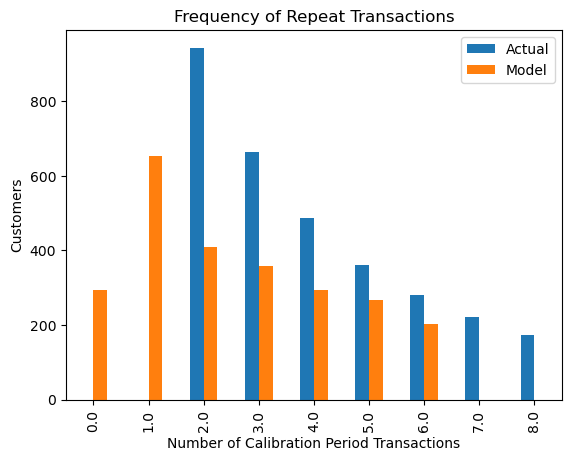

In [14]:
#evaluate prediction results
plot_period_transactions(bgf)
plt.show()

In [15]:
#set gamma gamma model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv_data["frequency"], clv_data["monetary"])

<lifetimes.GammaGammaFitter: fitted with 4255 subjects, p: 3.80, q: 0.34, v: 3.74>

In [16]:
#expected average profit
ggf.conditional_expected_average_profit(clv_data["frequency"], clv_data["monetary"]).head()

clv_data["expected_average_profit"] = ggf.conditional_expected_average_profit(clv_data["frequency"], clv_data["monetary"])

clv_data.head()

,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month,expected_purchase_3_month,expected_average_profit
Customer ID,,,,,,,,
12346.0000,57.1429,103.7143,12,58.6750,0.0078,0.0312,0.0930,59.8502
12347.0000,57.4286,57.8571,8,704.1650,0.1378,0.5496,1.6348,720.2151
12348.0000,51.7143,62.7143,5,398.3720,0.0833,0.3322,0.9886,413.4323
12349.0000,81.4286,84.2857,4,946.6250,0.0564,0.2249,0.6704,990.4172
12352.0000,50.8571,56.1429,10,209.8940,0.1682,0.6707,1.9950,213.9718


In [17]:
#Calculate CLV with BG-NBD (Beta-Geometric Negative Binomial Distribution) Model and Gamma-Gamma Model
clv = ggf.customer_lifetime_value(bgf,
                            clv_data["frequency"],
                            clv_data["recency"],
                            clv_data["T"],
                            clv_data["monetary"],
                            time=3, # month
                            freq="W",
                            discount_rate=0.01
                            )
clv.head()

clv = clv.reset_index()
clv.head()

clv_data.head()

clv_final = clv_data.merge(clv, on="Customer ID", how="left")

clv_final.head()

clv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month,expected_purchase_3_month,expected_average_profit,clv
4139,18102.0000,105.4286,105.5714,145,3726.6687,1.2669,5.0585,15.1038,3731.1484,59977.2936
1652,14646.0000,105.0000,105.4286,151,3361.4186,1.3198,5.2696,15.7341,3365.3009,56353.8064
1290,14156.0000,104.0000,105.5714,156,1903.5948,1.3530,5.4021,16.1299,1905.7332,32715.2369
1840,14911.0000,105.2857,105.5714,398,709.3988,3.4555,13.7967,41.1952,709.7169,31116.4208
3682,17450.0000,61.2857,62.7143,51,3334.3318,0.7172,2.8604,8.5177,3345.7601,30321.0143
1247,14096.0000,13.8571,14.5714,17,3163.4965,0.7448,2.9541,8.6876,3196.2592,29504.9871
51,12415.0000,71.8571,75.4286,28,5003.3098,0.3397,1.3555,4.0402,5034.5651,21644.1827
949,13694.0000,104.4286,105.1429,143,1338.7443,1.2527,5.0017,14.9339,1340.3929,21303.9852
3728,17511.0000,104.8571,105.4286,60,2924.4313,0.5315,2.1221,6.3359,2932.9545,19777.3847
3114,16684.0000,104.0000,104.7143,55,2513.8125,0.4911,1.9608,5.8542,2521.8167,15712.1036


In [18]:
#create segmentation
clv_final["segment"] = pd.qcut(clv_final["clv"], 4, labels=["D", "C", "B", "A"])

clv_final.head()

clv_final.groupby("segment").agg({"count", "sum", "mean"})

Customer ID                     recency                        T                  frequency              monetary                   expected_purchase_1_week                expected_purchase_1_month                expected_purchase_3_month                 expected_average_profit                         clv                   
               mean count           sum    mean count        sum    mean count        sum      mean count    sum     mean count         sum                     mean count      sum                      mean count      sum                      mean count       sum                    mean count         sum      mean count          sum
segment                                                                                                                                                                                                                                                                                                                                      
D        15424.8365  1064 16412026.0000 28.2350  1064 30042.0000 81.4737  1064 86688.0000    3.9098  1064   4160 252.2168  1064 268358.6403                   0.0159  1064  16.8946                    0.0633  1064  67.3615                    0.1884  1064  200.4694                270.5191  1064 287832.3358   34.6315  1064   36847.9688
C        15482.4549  1064 16473332.0000 59.5379  1064 63348.2857 75.8625  1064 80717.7143    4.5526  1064   4844 261.6415  1064 278386.5316                   0.0627  1064  66.6921                    0.2498  1064 265.7503                    0.7424  1064  789.8713                277.8487  1064 295630.9686  182.0232  1064  193672.6953
B        15254.7159  1063 16215763.0000 63.2309  1063 67214.4286 71.6072  1063 76118.4286    7.3208  1063   7782 354.2734  1063 376592.6326                   0.1071  1063 113.8369                    0.4265  1063 453.3745                    1.2663  1063 1346.1213                369.5932  1063 392877.5733  415.1721  1063  441327.9781
A        15077.2979  1064 16042245.0000 64.5265  1064 68656.1429 68.6866  1064 73082.5714   17.4436  1064  18560 593.3137  1064 631285.7256                   0.2283  1064 242.9221                    0.9091  1064 967.2948                    2.6985  1064 2871.2538                610.6443  1064 649725.5393 1683.5376  1064 1791284.0258

In [19]:
# Export results to Excel
clv_final.to_excel("clv_prediction.xlsx", index=False)

In [28]:
#functionalize all processes
def create_clv_prediction(dataframe,month=3,csv=False):
  # Data Preprocessing
  dataframe.dropna(inplace=True)
  dataframe = dataframe[~dataframe["Invoice"].str.contains("C",na=False)]
  dataframe = dataframe[dataframe["Quantity"] > 0]
  dataframe = dataframe[dataframe["Price"] > 0]
  replace_with_thresholds(dataframe,"Quantity")
  replace_with_thresholds(dataframe,"Price")
  dataframe["TotalPrice"] = dataframe["Price"] * dataframe["Quantity"]
  today_date = dt.datetime(2011,12,11)

  #Preparation of lifetime data structure
  clv_data = dataframe.groupby(["Customer ID"]).agg({'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                                    lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                                                    'Invoice': lambda Invoice: Invoice.nunique(),
                                                    'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
  clv_data.columns = clv_data.columns.droplevel(0)
  clv_data.columns = ["recency","T","frequency","monetary"]
  clv_data["monetary"] = clv_data["monetary"] / clv_data["frequency"]
  clv_data = clv_data[(clv_data["frequency"] > 1)]
  clv_data["recency"] = clv_data["recency"] / 7
  clv_data["T"] = clv_data["T"] / 7

  #Set the BG-NBD Model
  bgf = BetaGeoFitter(penalizer_coef=0.001)
  bgf.fit(clv_data["frequency"],clv_data["recency"],clv_data["T"])

  clv_data["expected_purchase_1_week"] = bgf.predict(1,clv_data["frequency"],clv_data["recency"],clv_data["T"])
  clv_data["expected_purchase_1_month"] = bgf.predict(4,clv_data["frequency"],clv_data["recency"],clv_data["T"])
  clv_data["expected_purchase_3_month"] = bgf.predict(12,clv_data["frequency"],clv_data["recency"],clv_data["T"])

  # Set the Gamma-Gamma Model
  ggf = GammaGammaFitter(penalizer_coef=0.01)
  ggf.fit(clv_data["frequency"],clv_data["monetary"])

  clv_data["expected_average_profit"] = ggf.conditional_expected_average_profit(clv_data["frequency"],clv_data["monetary"])

  # Calculating clv with BG-NBD Model and Gamma-Gamma Model
  clv = ggf.customer_lifetime_value(bgf,
                                     clv_data["frequency"],
                                     clv_data["recency"],
                                     clv_data["T"],
                                     clv_data["monetary"],
                                     time=month,
                                     freq="W",
                                     discount_rate=0.01)
  clv = clv.reset_index()
  clv_final = clv_data.merge(clv, on="Customer ID", how="left")

  # Creation of Segment
  clv_final["segment"] = pd.qcut(clv_final["clv"], 4, labels=["D","C","B","A"])

  return clv_final

df = data.copy()
create_clv_prediction(df, csv=True)

,Customer ID,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month,expected_purchase_3_month,expected_average_profit,clv,segment
0,12346.0000,57.1429,103.7143,12,58.6750,0.0055,0.0218,0.0648,59.8502,4.1290,D
1,12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,720.2151,1237.4448,A
2,12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,413.4323,428.6136,B
3,12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,990.4172,713.1659,A
4,12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,213.9718,443.0763,B
5,12353.0000,29.1429,58.4286,2,203.3800,0.0369,0.1471,0.4364,224.6973,104.2918,C
6,12355.0000,50.4286,81.1429,2,473.8050,0.0318,0.1269,0.3775,520.7427,209.1431,C
7,12356.0000,57.2857,60.7143,6,1062.2800,0.1026,0.4087,1.2122,1094.4767,1410.8826,A
8,12357.0000,50.7143,55.5714,3,5824.8667,0.0660,0.2629,0.7793,6182.8322,5123.4728,A
9,12358.0000,104.2857,104.5714,5,770.6820,0.0560,0.2234,0.6653,799.0927,565.6307,B
